<a href="https://colab.research.google.com/github/Ryukijano/Physics-Based-DeepLearning/blob/main/Differentiable_Fluid_Simulations_with_%CE%A6_Flow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Fluid Simulations with Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/Fluids_Tutorial.ipynb)

This notebook steps you through setting up fluid simulations and using TensorFlow's differentiation to optimize them.

Execute the cell below to install the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow).

In [1]:
!pip install --quiet phiflow
from phi.flow import *

## Setting up a Simulation

Φ<sub>Flow</sub> is vectorized but object-oriented, i.e. data are represented by Python objects that internally use tensors.

First, we create grids for the quantities we want to simulate. For this example, we require a velocity field and a smoke density field.
We sample the smoke field at the cell centers and the velocity in [staggered form](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html).

In [2]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40))  # sampled in staggered form at face centers

Additionally, we want to add more smoke every time step.
We create the `INFLOW` field from a circle (2D [`Sphere`](https://tum-pbs.github.io/PhiFlow/phi/geom/index.html#phi.geom.Sphere)) which defines where hot smoke is emitted.
Furthermore, we are interested in running the simulation for different inflow locations.

Φ<sub>Flow</sub> supports data-parallell execution via *batch dimensions*.
When a quantity has a batch dimension with size *n*, operations involving that quantity will be performed *n* times simultaneously and the result will also have that batch dimension. Here we add the batch dimension `inflow_loc`.

For an overview of the dimension types, see the [documentation](https://tum-pbs.github.io/PhiFlow/Math.html#shapes)
or watch the [introductory tutorial video](https://youtu.be/4nYwL8ZZDK8).

In [3]:
INFLOW_LOCATION = tensor([(4, 5), (8, 5), (12, 5), (16, 5)], batch('inflow_loc'), channel(vector='x,y'))
INFLOW = 0.6 * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))

The created grids are instances of the class `Grid`.
Like tensors, grids also have the `shape` attribute which lists all batch, spatial and channel dimensions.
[Shapes in Φ<sub>Flow</sub>](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) store not only the sizes of the dimensions but also their names and types.

In [4]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}")
print(f"Inflow, spatial only: {INFLOW.shape.spatial}")

Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (inflow_locᵇ=4, xˢ=32, yˢ=40)
Inflow, spatial only: (xˢ=32, yˢ=40)


The grid values can be accessed using the `values` property.

In [5]:
print(smoke.values)
print(velocity.values)
print(INFLOW.values)

(xˢ=32, yˢ=40) const 0.0
(xˢ=(x=31, y=32) int64, yˢ=(x=40, y=39) int64, vectorᶜ=x,y) non-uniform
(inflow_locᵇ=4, xˢ=32, yˢ=40) 0.015 ± 0.094 (0e+00...6e-01)


Grids have many more properties which are documented [here](https://tum-pbs.github.io/PhiFlow/phi/field/#phi.field.Grid).
Also note that the staggered grid has a [non-uniform shape](https://tum-pbs.github.io/PhiFlow/Math.html#non-uniform-tensors) because the number of faces is not equal to the number of cells.

## Running the Simulation

Next, let's do some physics!
Since the initial velocity is zero, we just add the inflow and the corresponding buoyancy force.
For the buoyancy force we use the factor `(0, 0.5)` to specify strength and direction.
Finally, we project the velocity field to make it incompressible.

Note that the `@` operator is a shorthand for resampling a field at different points. Since `smoke` is sampled at cell centers and `velocity` at face centers, this conversion is necessary.

/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)
/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:148: FutureWarning: Instance checks on PointCloud are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, PointCloud)


<Figure size 1200x500 with 8 Axes>

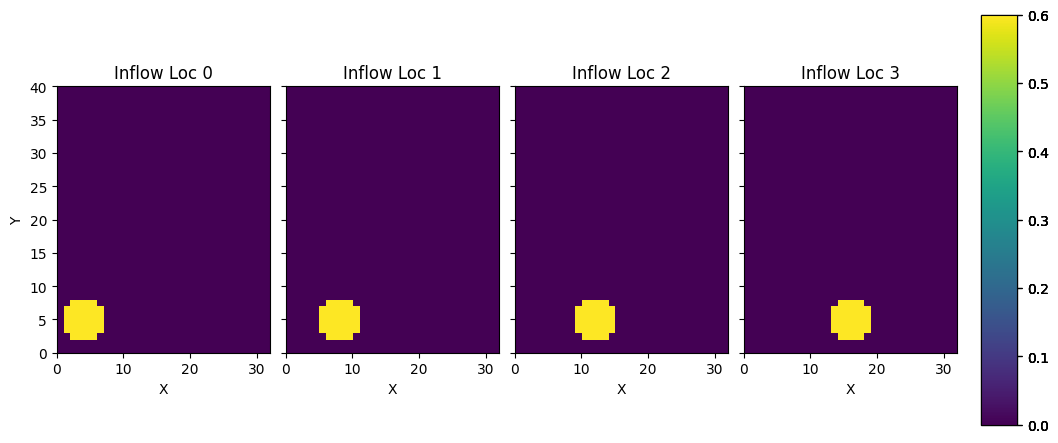

In [6]:
smoke += INFLOW
buoyancy_force = smoke * (0, 0.5) @ velocity
velocity += buoyancy_force
velocity, _ = fluid.make_incompressible(velocity)

vis.plot(smoke)

Let's run a longer simulation!
Now we add the transport or *advection* operations to the simulation.
Φ<sub>Flow</sub> provides multiple algorithms for advection.
Here we use semi-Lagrangian advection for the velocity and MacCormack advection for the smoke distribution.

In [7]:
trajectory = [smoke]
for i in range(20):
  print(i, end=' ')
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
  buoyancy_force = smoke * (0, 0.5) @ velocity
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _ = fluid.make_incompressible(velocity)
  trajectory.append(smoke)
trajectory = field.stack(trajectory, batch('time'))
vis.plot(trajectory, animate='time')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)
/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:148: FutureWarning: Instance checks on PointCloud are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, PointCloud)


## Obtaining Gradients

The simulation we just computed was using pure NumPy so all operations were non-differentiable.
To enable differentiability, we need to use either PyTorch, TensorFlow or Jax.
This can be achieved by changing the import statement to [`phi.tf.flow`](https://tum-pbs.github.io/PhiFlow/phi/tf/flow.html), [`phi.torch.flow`](https://tum-pbs.github.io/PhiFlow/phi/torch/flow.html) or [`phi.jax.flow`](https://tum-pbs.github.io/PhiFlow/phi/jax/index.html), respectively.
Tensors created after this import will be allocated using PyTorch / TensorFlow / Jax and operations on these will be executed with the corresponding backend.
These operations can make use of a GPU through CUDA if your configuration supports it.

In [8]:
# from phi.jax.flow import *
from phi.torch.flow import *
# from phi.tf.flow import *

We set up the simulation as before.

In [9]:
INFLOW_LOCATION = tensor([(4, 5), (8, 5), (12, 5), (16, 5)], batch('inflow_loc'), channel(vector='x,y'))
INFLOW = 0.6 * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))

We can verify that tensors are now backed by TensorFlow / PyTorch / Jax.

In [10]:
type(INFLOW.values.native(INFLOW.shape))

torch.Tensor

Note that tensors created with NumPy will keep using NumPy/SciPy operations unless a TensorFlow tensor is also passed to the same operation.

Let's look at how to get gradients from our simulation.
Say we want to optimize the initial velocities so that all simulations arrive at a final state that is similar to the right simulation where the inflow is located at `(16, 5)`.

To achieve this, we define the loss function as $L = | D(s - s_r) |^2$ where $s$ denotes the smoke density and the function $D$ diffuses the difference to smoothen the gradients.

In [11]:
def simulate(smoke: CenteredGrid, velocity: StaggeredGrid):
  for _ in range(20):
    smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
    buoyancy_force = smoke * (0, 0.5) @ velocity
    velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
    velocity, _ = fluid.make_incompressible(velocity)
  loss = math.sum(field.l2_loss(diffuse.explicit(smoke - field.stop_gradient(smoke.inflow_loc[-1]), 1, 1, 10)))
  return loss, smoke, velocity

Now it is important that the initial velocity has the `inflow_loc` dimension before we record the gradients.

In [12]:
initial_smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))
initial_velocity = StaggeredGrid(math.zeros(batch(inflow_loc=4)), extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40))

Finally, we use `gradient_function()` to obtain the gradient with respect to the initial velocity. Since the velocity is the second argument to the `simulate()` function, we pass `wrt=[1]`.

In [17]:
sim_grad = field.functional_gradient(simulate, wrt='velocity', get_output=False)

The argument `get_output=False` specifies that we are not interested in the actual output of the function. By setting it to `True`, we would also get the loss value and the final simulation state.

To evaluate the gradient, we simply call the gradient function with the same arguments as we would call the simulation.

/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)
/usr/local/lib/python3.10/dist-packages/phi/field/_field.py:148: FutureWarning: Instance checks on PointCloud are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, PointCloud)


<Figure size 1200x500 with 4 Axes>

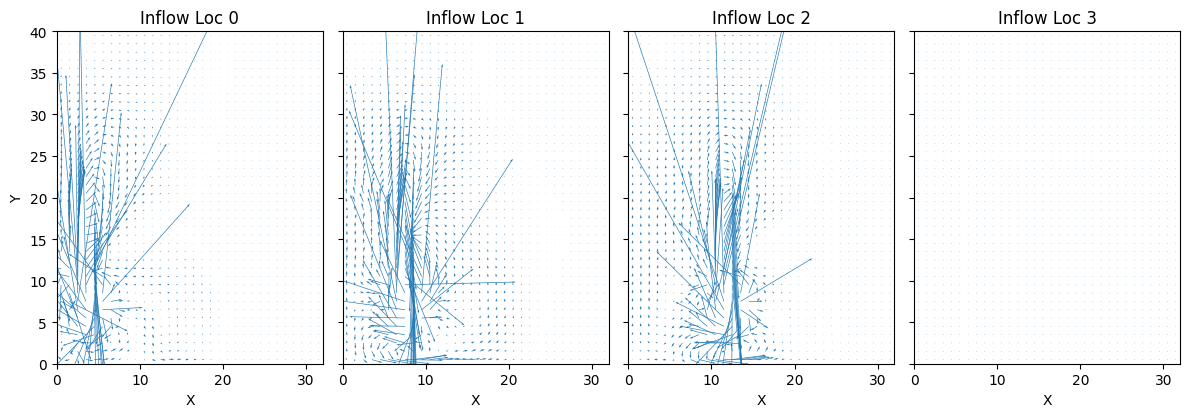

In [18]:
velocity_grad = sim_grad(initial_smoke, initial_velocity)

vis.plot(velocity_grad)

With the gradient, we can easily perform basic gradient descent optimization.
For more advanced optimization techniques and neural network training, see the [optimization documentation](https://tum-pbs.github.io/PhiFlow/Optimization.html).

In [19]:
print(f"Initial loss: {simulate(initial_smoke, initial_velocity)[0]}")
initial_velocity -= 0.01 * velocity_grad
print(f"Next loss: {simulate(initial_smoke, initial_velocity)[0]}")

Initial loss: (268.389, 214.372, 136.681, 0.000) along inflow_locᵇ
Next loss: (274.484, 239.472, 200.311, 0.000) along inflow_locᵇ


In [20]:
sim_grad = field.functional_gradient(simulate, wrt='velocity', get_output=True)

for opt_step in range(4):
  (loss, final_smoke, _v), velocity_grad = sim_grad(initial_smoke, initial_velocity)
  print(f"Step {opt_step}, loss: {loss}")
  initial_velocity -= 0.01 * velocity_grad

Step 0, loss: (274.484, 239.472, 200.311, 0.000) along inflow_locᵇ
Step 1, loss: (220.293, 177.164, 122.866, 0.000) along inflow_locᵇ
Step 2, loss: (216.105, 184.637, 82.620, 0.000) along inflow_locᵇ
Step 3, loss: (276.074, 183.645, 109.230, 0.000) along inflow_locᵇ


This notebook provided an introduction to running fluid simulations in NumPy and TensorFlow.
It demonstrated how to obtain simulation gradients which can be used to optimize physical variables or train neural networks.

The full Φ<sub>Flow</sub> documentation is available at [https://tum-pbs.github.io/PhiFlow/](https://tum-pbs.github.io/PhiFlow/).

Visit the [playground](https://colab.research.google.com/drive/1zBlQbmNguRt-Vt332YvdTqlV4DBcus2S#offline=true&sandboxMode=true) to run Φ<sub>Flow</sub> code in an empty notebook.